# Thermal IR Tutorial 2: Comparing raster and point datasets

**At the conclusion of this tutorial, you will be able to:**
- Visualize point and raster thermal infrared datasets together
- Compute error statistics between point and raster datasets

In [1]:
# Import the packages we'll need
import numpy as np # for working with n-D arrays
import pandas as pd # for reading our csv data file and working with tabular data
import matplotlib.pyplot as plt # for making plots

To provide a source of "ground truth" for the airborne and satellite thermal infrared images during the SnowEx 2020 Grand Mesa IOP, we can use ground-based snow surface temperature measurements. On February 5, 2020, we installed a thermal infrared radiometer pointing at the snow surface at snow pit #2S10, and buried temperature sensors beneath the snow surface. These logged observations at 5-minute intervals until we removed the instrumentation a week later on February 12.

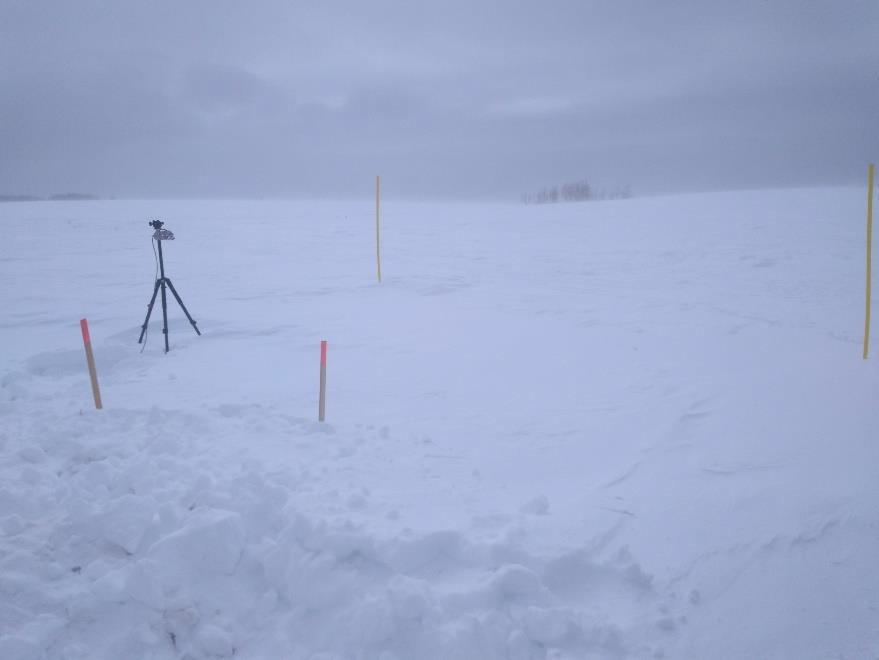

What are the differences we might expect to see between the ground point and the thermal IR data?
 - our ground based radiometer was looking at 45 deg off nadir, versus nadir ASTER versus variable view angle airborne (snow emissivity changes off-nadir)
 - band-width of the radiometer versus the airborne camera versus ASTER and spectral response functions
 - atmospheric path length (from < 1 meter, to 1 km, to whole atmosphere) (wind-blown snow aloft?)
 - "point" (actually some weighted value of a small ellipse on the ground) versus pixels of different sizes, their own point spread functions, and geolocation accuracy
 
 ---

Then unzip the folder we just downloaded (`-q` for "quiet mode" so it doesn't list every file as it unzips them, `-d` for the directory we want to unzip the files into

`unzip -q -d data/SNEX20_VPTS_Raw SNEX20_VPTS_Raw.zip`

And you should see the folder "Level-0" with the raw ground-based snow temperature data inside now in your data directory

The file we want is `data/SNEX20_VPTS_Raw/Level-0/snow-temperature-timeseries/CR10X_GM1_final_storage_1.dat`, this is a comma-delimited text file from the datalogger at snow pit 2S10

---

The data file doesn't include the column names, so we need to set the column headers following the dataset's README file.

In [2]:
column_headers = ['table', 'year', 'doy', 'time', # year, day of year, time of day (local time, UTC-7)
                  'rad_avg', 'rad_max', 'rad_min', 'rad_std', # radiometer surface temperature
                  'sb_avg', 'sb_max', 'sb_min', 'sb_std', # radiometer sensor body temperature (for calibration)
                  'temp1_avg', 'temp1_max', 'temp1_min', 'temp1_std', # temperature at 5 cm below snow surface
                  'temp2_avg', 'temp2_max', 'temp2_min', 'temp2_std', #               10 cm
                  'temp3_avg', 'temp3_max', 'temp3_min', 'temp3_std', #               15 cm
                  'temp4_avg', 'temp4_max', 'temp4_min', 'temp4_std', #               20 cm
                  'temp5_avg', 'temp5_max', 'temp5_min', 'temp5_std', #               30 cm
                  'batt_a','batt_b', # battery voltage data
                 ]

Open the file as a pandas data frame with read_csv

In [3]:
df = pd.read_csv('data/SNEX20_VPTS_Raw/Level-0/snow-temperature-timeseries/CR10X_GM1_final_storage_1.dat',
                 header = None, names = column_headers)

We need to do some formatting of the data fields, but we can preview what we just loaded fist

In [4]:
df.head() # show the first 5 rows of the dataframe

,table,year,doy,time,rad_avg,rad_max,rad_min,rad_std,sb_avg,sb_max,...,temp4_avg,temp4_max,temp4_min,temp4_std,temp5_avg,temp5_max,temp5_min,temp5_std,batt_a,batt_b
0,101,2020,30,1537,22.963,22.963,22.963,0.000,22.832,22.832,...,-99999.0,-99999.0,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0,22.96,22.83
1,101,2020,30,1538,22.962,22.963,22.961,0.001,22.832,22.832,...,-99999.0,-99999.0,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0,22.96,22.83
2,101,2020,30,1539,25.080,26.810,22.968,1.484,22.832,22.832,...,-99999.0,-99999.0,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0,24.47,22.83
3,101,2020,30,1540,25.320,25.569,25.133,0.184,22.839,22.846,...,-99999.0,-99999.0,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0,25.42,22.85
4,102,2020,30,1540,12.050,0.000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Data cleanup and formatting

In [5]:
# Create a zero-padded time string (e.g. for 9:30 AM we are changing '930' into '0930')
df['time_str'] = [('0' * (4 - len(str(df.time[i])))) + str(df.time[i]) for i in range(df.shape[0])]
# change midnight from '2400' to '0000'
df.time_str.replace('2400', '0000', inplace=True)

Convert year and day of year to pandas datetime index:

In [6]:
def compose_date(years, months=1, days=1, weeks=None, hours=None, minutes=None,
                 seconds=None, milliseconds=None, microseconds=None, nanoseconds=None):
    '''Compose a datetime object from various datetime components. This clever solusion is from:
        https://stackoverflow.com/questions/34258892/converting-year-and-day-of-year-into-datetime-index-in-pandas'''
    years = np.asarray(years) - 1970
    months = np.asarray(months) - 1
    days = np.asarray(days) - 1
    types = ('<M8[Y]', '<m8[M]', '<m8[D]', '<m8[W]', '<m8[h]',
             '<m8[m]', '<m8[s]', '<m8[ms]', '<m8[us]', '<m8[ns]')
    vals = (years, months, days, weeks, hours, minutes, seconds,
            milliseconds, microseconds, nanoseconds)
    return sum(np.asarray(v, dtype=t) for t, v in zip(types, vals)
               if v is not None)

In [7]:
# Create a datetime value from the date field and zero-padded time_str field, set this as our dataframe's index
df.index = compose_date(df['year'], 
                        days=df['doy'], 
                        hours=df['time_str'].str[:2],
                        minutes=df['time_str'].str[2:])

In [8]:
# Remove entries that are from table "102" (this contains datalogger battery information we're not interested in at the moment)
df = df[df.table != 102]

In [9]:
# drop the columns we no longer need
df.drop(columns=['table','year','doy','time','time_str','batt_a','batt_b'], inplace=True)

In [10]:
df.head()

,rad_avg,rad_max,rad_min,rad_std,sb_avg,sb_max,sb_min,sb_std,temp1_avg,temp1_max,...,temp3_min,temp3_std,temp4_avg,temp4_max,temp4_min,temp4_std,temp5_avg,temp5_max,temp5_min,temp5_std
2020-01-30 15:37:00,22.963,22.963,22.963,0.000,22.832,22.832,22.832,0.000,-99999.0,-99999.0,...,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0
2020-01-30 15:38:00,22.962,22.963,22.961,0.001,22.832,22.832,22.832,0.000,-99999.0,-99999.0,...,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0
2020-01-30 15:39:00,25.080,26.810,22.968,1.484,22.832,22.832,22.832,0.000,-99999.0,-99999.0,...,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0
2020-01-30 15:40:00,25.320,25.569,25.133,0.184,22.839,22.846,22.832,0.005,-99999.0,-99999.0,...,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0
2020-01-30 15:41:00,24.894,25.069,24.611,0.182,22.860,22.860,22.860,0.000,-99999.0,-99999.0,...,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0,-99999.0,-99999.0,-99999.0,0.0


Plot

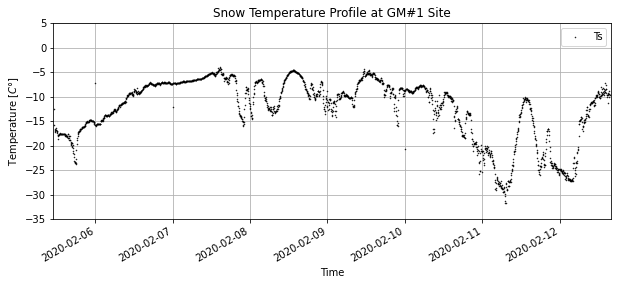

In [11]:
plt.figure(figsize=(10,4))

#df.temp1_avg.plot(linestyle='none', marker='.', markersize=1, c=[0.8,0.8,1], label='-5 cm')
#df.temp2_avg.plot(linestyle='none', marker='.', markersize=1, c=[0.6,0.6,1], label='-10 cm')
#df.temp3_avg.plot(linestyle='none', marker='.', markersize=1, c=[0.4,0.4,1], label='-15 cm')
#df.temp4_avg.plot(linestyle='none', marker='.', markersize=1, c=[0.2,0.2,1], label='-20 cm')
#df.temp5_avg.plot(linestyle='none', marker='.', markersize=1, c=[0,0,1], label='-30 cm')
df.rad_avg.plot(linestyle='none', marker='.', markersize=1, c='k', label='Ts')
plt.ylim((-35,5))
plt.xlim((pd.Timestamp(2020,2,5,11,0),pd.Timestamp(2020,2,12,16,0)))
plt.legend()
plt.ylabel('Temperature [$C\degree$]')
plt.xlabel('Time')
plt.grid('on')
plt.title('Snow Temperature Profile at GM#1 Site');

Zoom in on Feb 8th

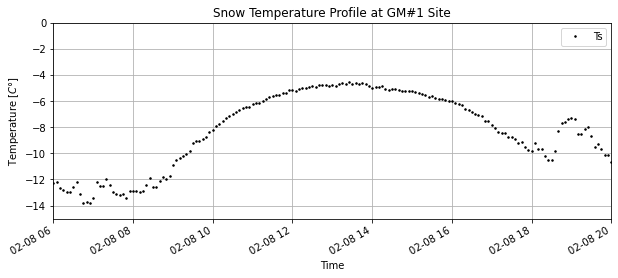

In [12]:
plt.figure(figsize=(10,4))

#df.temp1_avg.plot(linestyle='none', marker='.', markersize=1, c=[0.8,0.8,1], label='-5 cm')
#df.temp2_avg.plot(linestyle='none', marker='.', markersize=1, c=[0.6,0.6,1], label='-10 cm')
#df.temp3_avg.plot(linestyle='none', marker='.', markersize=1, c=[0.4,0.4,1], label='-15 cm')
#df.temp4_avg.plot(linestyle='none', marker='.', markersize=1, c=[0.2,0.2,1], label='-20 cm')
#df.temp5_avg.plot(linestyle='none', marker='.', markersize=1, c=[0,0,1], label='-30 cm')
df.rad_avg.plot(linestyle='none', marker='.', markersize=3, c='k', label='Ts')
plt.ylim((-15,0))
plt.xlim((pd.Timestamp(2020,2,8,6,0),pd.Timestamp(2020,2,8,20,0)))
plt.legend()
plt.ylabel('Temperature [$C\degree$]')
plt.xlabel('Time')
plt.grid('on')
plt.title('Snow Temperature Profile at GM#1 Site');

Load raster data from previous notebook for comparison with the ground data on Feb 8th